# Skojarzenia w dowolnych grafach

$\textbf{Autor:}$ Adam Michalski

## Import potrzebnych bibliotek

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import display
from queue import PriorityQueue
import os
import wget

## Klasa implementująca graf

In [2]:
class Graph:
    def __init__(self, graph_dict={}, is_directed=False):
        self.dict = graph_dict
        self.is_directed = is_directed

    # dict initializer
    @classmethod
    def from_dict(cls, graph, is_directed):
        return cls(graph, is_directed)

    # array initializer
    @classmethod
    def from_matrix(cls, matrix, vertices = None):
        if vertices is None:
            vertices = [*range(1, len(matrix) + 1)]
        return cls.from_dict(cls._matrix_to_dict(matrix, vertices))

    def _matrix_to_dict(matrix, vertices: list) -> dict:
        """
        Converts a graph given as an adjacency matrix to a graph in dictionary of neighbours form.
        """
        result = {}
        for i, v in enumerate(vertices):
            neighbours = [vertices[j] for j, edge in enumerate(matrix[i]) if edge]
            result[v] = neighbours
        return result

    def _dict_to_matrix(self, _dict: dict) -> np.array:
        """
        Converts a graph in in dictionary of neighbours form to its adjacency matrix.
        """
        n = len(_dict)
        vertices = [*_dict.keys()]
        matrix = np.zeros(shape = (n, n), dtype=int)
        for u,v in [
            (vertices.index(u), vertices.index(v))
            for u, row in _dict.items() for v in row
        ]:
            matrix[u][v] += 1
        return matrix

    def __str__(self):
        result = ""
        for v in self.dict:
            result += f"{v}:"
            for u in self.dict[v]:
                result += f" {u}"
            result += "\n"
        return result

    def plot(self, random_seed=1):
        G = None
        arrows_style = None
        if self.is_directed:
            G = nx.DiGraph()
            arrows_style = "-|>"
        else:
            G = nx.Graph()
            arrows_style = "-"
        G.add_nodes_from(self.dict.keys())
        pos = nx.spring_layout(G, seed=random_seed)

        for vertex, neighbours in self.dict.items():
            for neighbour in neighbours:
                G.add_edge(vertex, neighbour)

        nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray',
                node_size=1000, arrows=True, arrowstyle=arrows_style)
        plt.title("Graph Visualization")
        plt.show()

    def add_vertex(self, vertex):
        """
        Dodaje nowy wierzchołek do grafu.
        """
        if vertex not in self.dict.keys():
            self.dict[vertex] = []

    def add_arc(self, arc):
        """
        Dodaje nowy łuk do grafu skierowanego.
        """
        if self.is_directed:
            u, v = arc
            self.add_vertex(u)
            self.add_vertex(v)
            if v not in self.dict[u]:
                self.dict[u].append(v)
        else:
            raise ValueError("Operacja dodania łuku nie jest dozwolona dla grafów nieskierowanych.")

    def add_edge(self, edge):
        """
        Dodaje nową krawędź do grafu nieskierowanego.
        """
        if not self.is_directed:
            u, v = edge
            self.add_vertex(u)
            self.add_vertex(v)
            if u == v:
                raise ValueError("Pętla niedozwolona.")
            if v not in self.dict[u]:
                self.dict[u].append(v)
            if u not in self.dict[v]:
                self.dict[v].append(u)
        else:
            raise ValueError("Operacja dodania krawędzi nie jest dozwolona dla grafów skierowanych.")

    #Funkcje generujące grafy losowe
    @staticmethod
    def generate_random_graph(vertices_count: int, prob=1/2, random_seed=None):
        """
        Generates a random undirected graph with the given number of vertices and given probability of an edge appearing.
        """
        random_state = np.random.default_rng(random_seed)
        random_graph = Graph({}, is_directed=False)
        for i in range(1, vertices_count+1):
            random_graph.add_vertex(i)
            for j in range(1, i):
                if random_state.random() < prob:
                    random_graph.add_edge((i, j))

        return random_graph

    @staticmethod
    def generate_random_cycle(vertices_count: int, random_seed=None):
        """
        Generates a random undirected cycle with the given number of vertices.
        """
        random_state = np.random.default_rng(random_seed)
        random_cycle = Graph({}, is_directed=False)

        vertices = list(range(1, vertices_count + 1))
        for v in vertices:
            random_cycle.add_vertex(v)

        random_state.shuffle(vertices)

        for i in range(len(vertices) - 1):
            random_cycle.add_edge((vertices[i], vertices[i+1]))
        random_cycle.add_edge((vertices[-1], vertices[0]))
        return random_cycle

    @staticmethod
    def generate_random_bipartite_graph(vertices_count1: int, vertices_count2: int, prob=1/2, random_seed=None):
        """
        Generates a random bipartite graph with the given number of vertices in each group and given probability of an edge.
        """
        random_state = np.random.default_rng(random_seed)

        total_vertices = vertices_count1 + vertices_count2
        left_vertices = list(range(vertices_count1))
        right_vertices = list(range(vertices_count1, total_vertices))
        graph_dict = {v: [] for v in range(total_vertices)}

        for u in left_vertices:
            for v in right_vertices:
                if random_state.random() < prob:
                    graph_dict[u].append(v)
                    graph_dict[v].append(u)

        random_bipartite_graph = Graph(graph_dict, is_directed=False)
        return random_bipartite_graph

    #Funkcje do odczytu i zapisu grafów
    def to_edges_list_file(self, filename):
        """
        Zapisuje graf do pliku w formie listy sąsiedztwa.
        """
        with open(filename, "w") as file:
            for u in self.dict:
                for v in self.dict[u]:
                    line = f"{u} {v}\n"
                    file.write(line)

    def to_neighbours_list_file(self, filename):
        """
        Zapisuje graf do pliku w formie listy sąsiedztwa.
        """
        with open(filename, "w") as file:
            file.write(str(self))

    @staticmethod
    def from_edges_list_file(filename, is_directed=False):
        """
        Wczytuje graf z pliku w postaci listy krawędzi.
        """
        new_graph = Graph({}, is_directed=is_directed)
        file = open(filename, "r")
        with open(filename, "r") as file:
            for line in file:
                words = line.strip().split()
                if len(words) == 1:
                    new_graph.add_vertex(words[0])
                elif len(words) >= 2:
                    if is_directed:
                        new_graph.add_arc(words)
                    else:
                        new_graph.add_edge(words)
        return new_graph

    @staticmethod
    def from_neighbours_list_file(filename, is_directed=False):
        """
        Wczytuje graf z pliku w postaci listy sąsiedztwa.
        """
        new_graph = Graph({}, is_directed=is_directed)
        file = open(filename, "r")
        with open(filename, "r") as file:
            for line in file:
                words = line.replace(":", "").strip().split()
                starting_vertex = words[0]
                if len(words) == 1:
                    new_graph.add_vertex(starting_vertex)
                elif len(words) >= 2:
                    for ending_vertex in words[1:]:
                        if is_directed:
                            new_graph.add_arc((starting_vertex, ending_vertex))
                        else:
                            new_graph.add_edge((starting_vertex, ending_vertex))
        return new_graph

    #Funkcje do kodów Prufera i drzew
    def Prufer_code(self):
      """
      Returns the Prufer code of a tree.
      It is necessary that the graph is a tree (it is not checked).
      Result is given as a string (empty for trees on 1 or 2 vertices).
      """
      tr = deepcopy(self.dict)   # copy of a tree, as we destroy it
      code = ""
      for i in range(len(self.dict) - 2):
        for x in sorted(tr):
          if len(tr[x]) == 1:   # least leaf
            break
        v = tr[x][0]            # the unique neighbour of x
        code = code + f"{v} "
        tr[v].remove(x)         # remove x from neighbours of v
        tr.pop(x)               # remove x from the tree
      return code.strip()

    @staticmethod
    def tree_from_Prufer(code: str):
        """
        Creating a tree from a Prufer code.
        """
        tree = Graph({}, is_directed=False)
        clist = [int(x) for x in code.strip().split()]   # code as a list of numbers
        n = len(clist) + 2                  # number of vertices
        vert = [*range(1, n+1)]             # list of numbers 1..n
        for v in vert:
          tree.add_vertex(v)
        for i in range(n-2):
          for x in vert:
             if not x in clist:    # x - least leaf
                break
          v = clist.pop(0)    # remove the first element from the code - the neighbour of x
          tree.add_edge((x, v))
          vert.remove(x)
        tree.add_edge(vert)
        return tree

    def preorder(self, start):
        """
        Finds a preorder using Depth first search starting from the given vertex.
        """
        visited = set()
        preorder = []

        def dfs(vertex):
            visited.add(vertex)
            preorder.append(vertex)
            for neighbour in self.dict[vertex]:
                if neighbour not in visited:
                    dfs(neighbour)

        dfs(start)
        return preorder

    def postorder(self, start):
        """
        Finds a postorder using Depth first search starting from the given vertex.
        """
        visited = set()
        postorder = []

        def dfs(vertex):
            visited.add(vertex)
            for neighbour in self.dict[vertex]:
                if neighbour not in visited:
                    dfs(neighbour)
            postorder.append(vertex)

        dfs(start)
        return postorder

    def distances(self, v):
        """
        Oblicza odległości z wierchołka v do każdego wierchołka z grafu.
        """
        dist = {v: 0}
        queue = [v]
        while len(queue) > 0:
            u = queue.pop(0)
            for w in self.dict[u]:
                if not w in dist:
                    dist[w] = dist [u] + 1
                    queue.append(w)
        return dist

    #Spójne składowe i sortowanie topologiczne
    def connected_componentsDFS(self):
        """
        Finds all vertices of connected components of the graph using DFS.
        """
        def dfs(u):
            for w in self.dict[u]:
                if w not in VT[0]:
                    VT[0].add(w)
                    VT[-1].add(w)
                    dfs(w)


        VT = [set()]
        for v in self.dict:
            if not v in VT[0]:
                VT[0].add(v)
                VT.append(set([v]))
                dfs(v)
        return VT[1:]

    def connected_componentsBFS(self):
        """
        Finds all vertices of connected components of the graph using iterative BFS.
        """
        visited = set()
        components = []

        for start in self.dict:
            if start in visited:
                continue

            queue = PriorityQueue()
            queue.put(start)
            visited.add(start)
            component = []

            while not queue.empty():
                vertex = queue.get()
                component.append(vertex)

                for neighbour in self.dict[vertex]:
                    if neighbour not in visited:
                        visited.add(neighbour)
                        queue.put(neighbour)

            components.append(component)

        return components

    def connected_components(self, version="DFS"):
        """
        Finds all connected components of a graph.
        """
        components = []
        if version == "DFS":
            components = self.connected_componentsDFS()
        if version == "BFS":
            components = self.connected_componentsBFS()
        component_graphs = []
           
        for component in components:
            subgraph = Graph({}, is_directed=self.is_directed)
            for vertex in component:
                subgraph.dict[vertex] = self.dict[vertex].copy()
            component_graphs.append(subgraph)
        return component_graphs

    def transpose(self):
        """
        Returns a transposition of a graph.
        """
        graph_T = {}
        if self.is_directed:
            for u in self.dict:
                graph_T.setdefault(u, [])
            for u, neighbors in self.dict.items():
                for v in neighbors:
                    graph_T.setdefault(v, []).append(u)
        else:
            graph_T = self.dict
        self.T = Graph(graph_T, self.is_directed)
        return graph_T
        
    def strongly_connected_components_vertices(self):
        """
        Finds all vertices of strongly connected components of the directed graph using DFS and graph trasposition.
        """
        if not self.is_directed:
            raise ValueError("Strongly connected components require a directed graph")

        visited = set()
        finish_stack = []

        # First DFS on full graph to fill finish_stack with vertices by finish time
        def dfs_fill(u):
            visited.add(u)
            for v in self.dict[u]:
                if v not in visited:
                    dfs_fill(v)
            finish_stack.append(u)

        for vertex in self.dict:
            if vertex not in visited:
                dfs_fill(vertex)

        # Second DFS on transposed graph
        visited.clear()
        strong_components = []

        def dfs_collect(u, component):
            visited.add(u)
            component.append(u)

            transposed_dict = self.transpose()[u]
            for v in transposed_dict:
                if v not in visited:
                    dfs_collect(v, component)

        while finish_stack:
            vertex = finish_stack.pop()
            if vertex not in visited:
                strong_component = []
                dfs_collect(vertex, strong_component)
                strong_components.append(strong_component)

        return strong_components

    def strongly_connected_components(self):
        """
        Finds all strongly connected components graphs of a directed graph.
        """
        components = self.strongly_connected_components_vertices()
        component_graphs = []
           
        for component_vertices in components:
            subgraph_dict = {}
            # include only edges where both endpoints are in omponent_vertices
            component_set = set(component_vertices)
            for u in component_vertices:
                subgraph_dict[u] = [v for v in self.dict[u] if v in component_set]
            subgraph = Graph(subgraph_dict, is_directed=self.is_directed)
            component_graphs.append(subgraph)
        return component_graphs
    
        
    def topological_sort(self):
        """
        Performs a topological sort of a directed acyclic graph using Kahn's algorithm.
        """
        if not self.is_directed:
            raise ValueError("Topological sort requires a directed graph.")

        vertices = set(self.dict.keys())
        indegree = {vertex: 0 for vertex in vertices}
        
        for u, neighbours in self.dict.items():
            for v in neighbours:
                indegree[v] = indegree[v] + 1

        # Initialize queue with zero in-degree nodes
        queue = PriorityQueue()
        for node, deg in indegree.items():
            if deg == 0:
                queue.put(node)

        topological_order = []
        while not queue.empty():
            u = queue.get()
            topological_order.append(u)

            for v in self.dict.get(u, []):
                indegree[v] -= 1
                if indegree[v] == 0:
                    queue.put(v)

        if len(topological_order) != len(vertices):
            raise ValueError("Graph has at least one cycle, so topological sort is not possible.")

        return topological_order

## Algorytm kwiatowy Jacka Edmondsa (Edmond's blossom algorithm)

In [3]:
def blossom_max_matching(graph: Graph, verbose=False):
    """
    Implementuje algorytm kwiatowy Jacka Edmondsa (Edmond's blossom algorithm) znajdujący maksymalne skojarzenia w podanym grafie.
    
    Parameters
    ----------
    graph : undirected Graph
        Graf, którego maksymalne skojarzenia są szukane.

    Returns
    -------
        
    matchings : dict
        Słownik przypisujący każdemu wierzchołkowi skojarzony z nim wierzchołek albo None, gdy takowy ile istnieje.

    max_matchings: Int
        Maksymalna ilość skojarzeń w danych grafie.
        
    """

    def common_blossom_link(a, b):
        """
        Znajduje najwcześniejszy wspólny wierchołek dwóch wierzchołków w przypadku wykrycia cyklu nieparzystego (blossom).

        Parameters
        ----------
        a : String
            wierchołek grafu
        b : String
            wierchołek grafu
            
        Effects
        -------
        Przechodzi graf z obu wierzchołków aktualizując poprzedników dotychczasowych skojarzeń aż do znaleznia wierchołka najbliższego obu z nich.
        """
        visited = set()
        # Dopóki istnieje wierchołek skojarzony z a, zastępujemy go jego poprzednikiem rozpoczynając od korzenia składowej do której należy a.
        while True:
            a = base[a]
            visited.add(a)
            if matchings[a] is None:
                break
            a = parent[matchings[a]]
        # Dopóki istnieje wierchołek skojarzony z b, zastępujemy go jego poprzednikiem rozpoczynając od korzenia składowej do której należy b.
        while True: 
            b = base[b]
            if b in visited:
                return b
            b = parent[matchings[b]]

    def mark_blossom_path(v, b, x):
        """
        Zaznacza wszystkie wierzchołki na ścieżce od wierchołka v do korzenia(base) b jako elementy cyklu nieparzystego (blossom).

        Parameters
        ---------
        v : vertex
            Wierchołek startowy alternującej ścieżki.
        b : vertex
            Wspólny przodek (base) cyklu nieparzystego.
        x : vertex
            Drugi wierzchołek startowy alternującej ścieżki.
            
        Effects
        -------
        Zaznacza wierchołki grafu należące do cyklu nieparzystego na ścieżce od wierchołka v do korzenia b.
        """
        # Dopóki korzeniem obecnego wierzchołka nie jest korzeń (base) oznaczamy wierzchołki w cyklu nieparzystym.
        while base[v] != b:
            blossom[base[v]] = True
            blossom[base[matchings[v]]] = True
            parent[v] = x
            x = matchings[v]
            v = parent[matchings[v]]

    def find_path(root):
        """
        Parameters
        ----------
        root : vertex
            Wierchołek startowy alternującego przeszukiwania grafu.

        Effects
        -------
        Aktualizuje dotychczasowe maksymalne skojarzenie.
        
        Returns
        -------
            
        new_matching : bool
            Zwraca True, jeżeli udało się znaleźć krawędź rozszerzającą dotychczasowe skojarzenie. W przeciwnym wypadku zwraca False.

        """
        #Reset informacji o dotychczasowym przeszukiwaniu w szerz.
        for v in graph.dict:
            used[v] = False
            parent[v] = None
            base[v] = v
            blossom[v] = False

        #Tworzenie kolejki
        queue = PriorityQueue()
        queue.put(root)
        used[root] = True

        if verbose:
            print(f"Starting alternating depth first search from vertex {root}.")
        
        # Przeszukiwanie grafu alterując po wierchołkach wszerz aż do opróżnienia kolejki lub znalezienia nowego skojarzenia.
        #Wykryte cykle nieparzyste traktowane są jako pojedyńcze wierzchołki o krawędziach, 
        #których dokładnie jeden wierzchołek znajduje się w cyklu nieparzystym (blossom).
        while not queue.empty():
            v = queue.get()
            for u in graph.dict[v]:
                # Jeżeli u i v są w tym samym cyklu nieparzystym lub są połączone krawędzią pomiń iterację.
                if base[v] == base[u] or matchings[v] == u:
                    continue
                # Jeżeli sąsiad v jest wierchołkiem początkowym (występuje cykl) lub 
                # u jest takim wierchołkiem, że jego skojarzenie było odwiedzone:   
                if u == root or (matchings[u] is not None and parent[matchings[u]] is not None):
                    blossom_base = common_blossom_link(v, u)
                    if verbose:
                        cycle_vertices = {blossom_base}
                        x = v
                        while base[x] != blossom_base:
                            cycle_vertices.add(x)
                            cycle_vertices.add(matchings[x])
                            x = parent[ matchings[x] ]
                        cycle_vertices.add(blossom_base)

                        x = u
                        while base[x] != blossom_base:
                            cycle_vertices.add(x)
                            cycle_vertices.add(matchings[x])
                            x = parent[ matchings[x] ]
                        cycle_vertices.add(blossom_base)
                        cycle_vertices_list = list(cycle_vertices)
                        print(f"Detected the following blossom:")
                        cycle = Graph({}, is_directed=False)
                        n = len(cycle_vertices_list)
                        for i in range(n):
                            cycle.add_edge((cycle_vertices_list[i], cycle_vertices_list[(i + 1) % n]))
                        cycle.plot()
                        
                        
                    #Resetowanie informacji o przynależności do cyklu nieparzystego.
                    for w in graph.dict:
                        blossom[w] = False
                    # Oznaczanie wspólnego korzenia wierchołków wykrytego cyklu nieparzystego.
                    mark_blossom_path(v, blossom_base, u)
                    mark_blossom_path(u, blossom_base, v)
                    for w in graph.dict:
                        if blossom[base[w]]:
                            base[w] = blossom_base
                            if not used[w]:
                                used[w] = True
                                queue.put(w)
                #Jeżeli u jest nieodwiedzonym wierchołkiem bez żadnego odwiedzonego skojarzenia:
                elif parent[u] is None:
                    parent[u] = v
                    #Jeżeli u jest nieodwiedzonym wierchołkiem bez żadnego skojarzenia:
                    if matchings[u] is None:
                        matching_candidate = u
                        # Naprzemienne zamienianie początków i końców krawędzi w skojarzeniu na ścieżce od wierchołka root do wierchołka u
                        # powiększając dotychczasowego skojarzenia
                        while matching_candidate is not None:
                            previous_candidate = parent[matching_candidate]
                            if previous_candidate is not None:
                                next_candidate = matchings[previous_candidate] 
                            else:
                                None
                            matchings[matching_candidate] = previous_candidate
                            matchings[previous_candidate] = matching_candidate
                            #if verbose:
                            #    print(f"Vertex {matching_candidate} was matched with {previous_candidate}.")
                            matching_candidate = next_candidate
                        return True
                    #Jeżeli u jest nieodwiedzonym wierchołkiem ze skojarzeniem, włożenie skojarzonego wierchołka do kolejki. 
                    used[matchings[u]] = True
                    queue.put(matchings[u])
        return False

    #Inicjalizacja:
    matchings = {v: None for v in graph.dict} # Słownik przypisujący wierzchołkowi wierchołek z nim skojarzony albo None, gdy takowy nie istnieje.
    base = {v: v for v in graph.dict} # Słownik przypisujący każdemu wierzchołkowi korzeń (base) składowej do którego ten wierzchołek należy.
    parent = {v: None for v in graph.dict} # Słownik przechowywujący poprzednika wierzchołka w przeszukiwaniu w szerz.
    used = {v: False for v in graph.dict} # Słownik przechowujący informację, czy dany wierchołek był już odwiedzony.
    blossom = {v: False for v in graph.dict} # Słownik przechowujący informację, czy dany wierchołek znajduje się w cyklu nieparzystym (blossom).
    blossoms_found = [] # Słownik przechowujący informację, czy dany wierchołek znajduje się w cyklu nieparzystym (blossom).
    
    # Powiększanie skojarzeń próbując powiększać je zaczynając od każdego z wierchołków zliczając obecny rozmiar skojarzenia.
    max_matchings = 0
    for v in graph.dict:
        if matchings[v] is None:
            if find_path(v):
                max_matchings += 1
                if verbose:
                    print(f"Current matching increased to size {max_matchings}. Current matching is visualised on the following graph:")
                    filtered_matchings = {k: [v] for k, v in matchings.items() if v is not None}
                    matchings_graph = Graph(filtered_matchings)
                    matchings_graph.plot()

    return matchings, max_matchings

## Przykłady

Najpierw tworzymy listy krawędzi definiujące rozważane grafy w których będziemy poszukiwać maksymalnych skojarzeń:

In [4]:
%%writefile graf_dwudzielny.txt
a d
a e
b f
c e
c f

Overwriting graf_dwudzielny.txt


In [5]:
%%writefile cykl_3elementowy.txt
1 2
2 3
2 5
3 1
3 4
4 6

Overwriting cykl_3elementowy.txt


In [6]:
%%writefile cykle_3i5elementowe.txt
a b
b c
c a
d e
e f
f g
g h
h d
b h
b i
h j

Overwriting cykle_3i5elementowe.txt


Wyniki algorytmu dla grafu dwudzielnego:

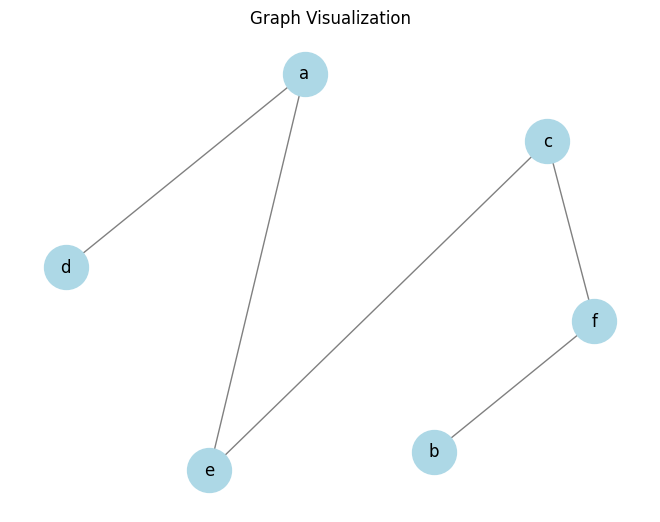

Starting alternating depth first search from vertex a.
Current matching increased to size 1. Current matching is visualised on the following graph:


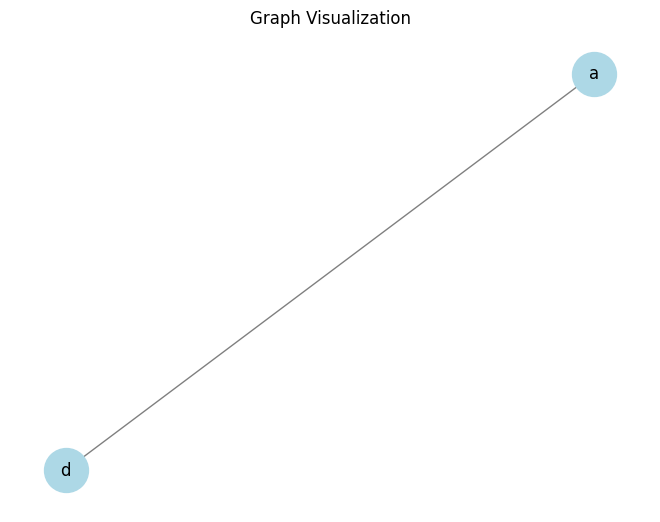

Starting alternating depth first search from vertex e.
Current matching increased to size 2. Current matching is visualised on the following graph:


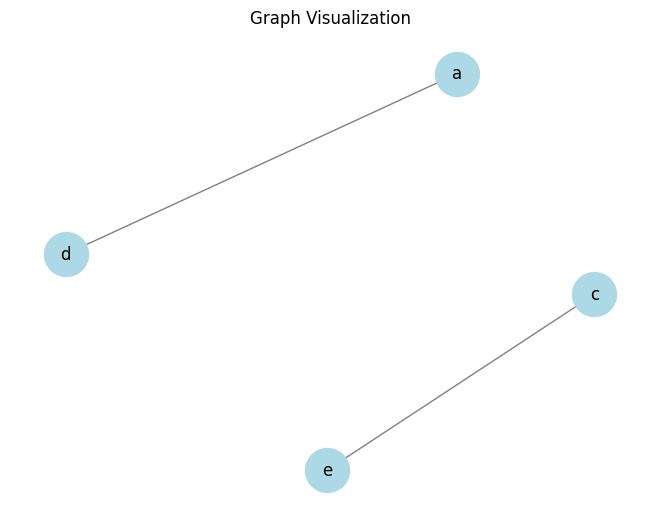

Starting alternating depth first search from vertex b.
Current matching increased to size 3. Current matching is visualised on the following graph:


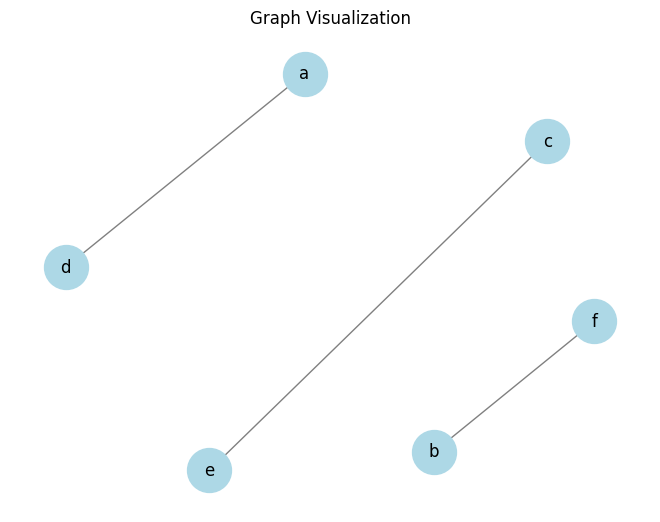

Maksymalna ilość skojarzeń: 3
Przykładowe maksymalne skojarzenia: {('c', 'e'), ('b', 'f'), ('a', 'd')}


In [7]:
graf_dwudzielny = Graph.from_edges_list_file("graf_dwudzielny.txt", is_directed=False)
graf_dwudzielny.plot()
matchings, max_matchings  = blossom_max_matching(graf_dwudzielny, verbose=True)
print(f"Maksymalna ilość skojarzeń: {max_matchings}")
print("Przykładowe maksymalne skojarzenia:", set([(u, v) for u, v in matchings.items() if u < (v or u)]))

Wyniki algorytmu dla grafu z cyklem nieparzystym długości 3:

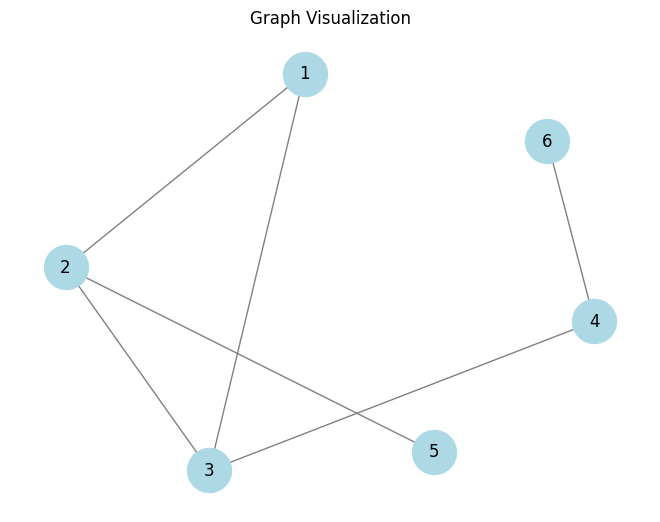

Starting alternating depth first search from vertex 1.
Current matching increased to size 1. Current matching is visualised on the following graph:


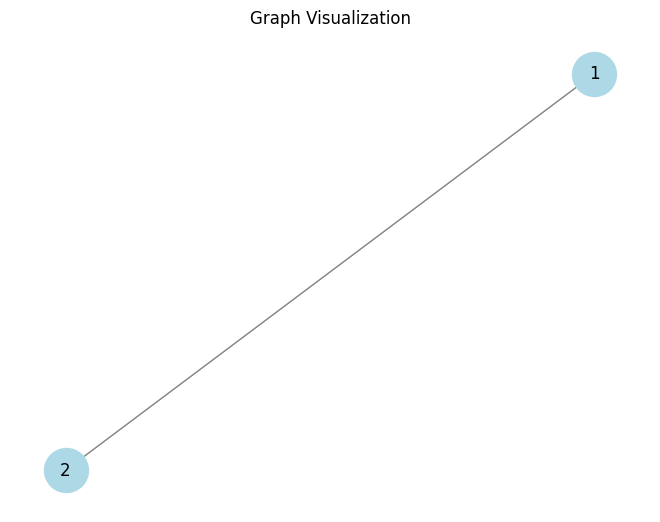

Starting alternating depth first search from vertex 3.
Detected the following blossom:


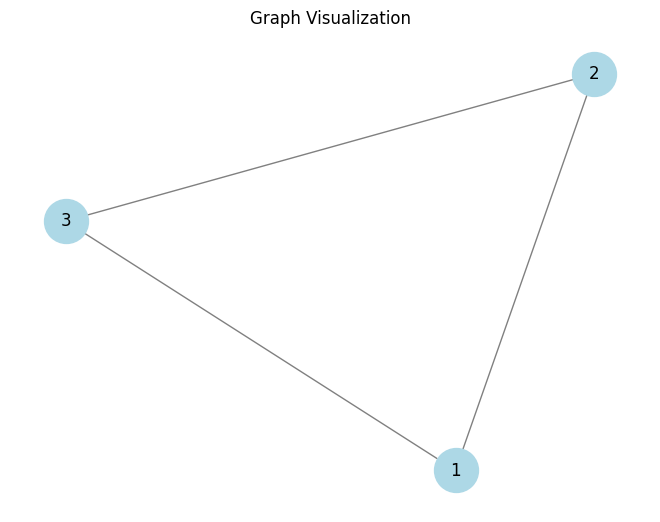

Current matching increased to size 2. Current matching is visualised on the following graph:


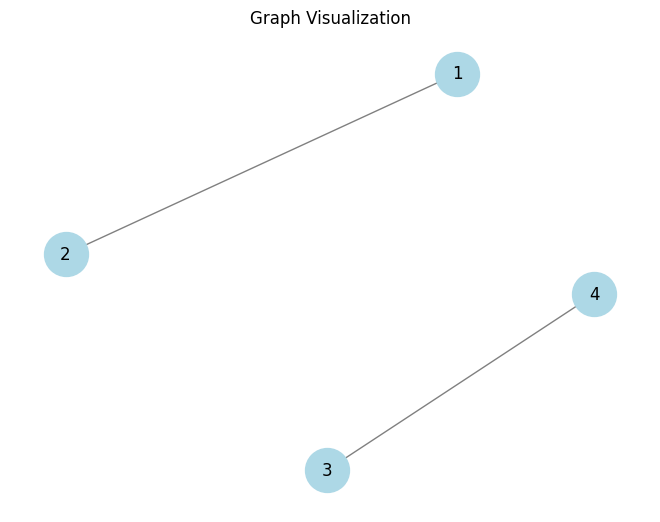

Starting alternating depth first search from vertex 5.
Current matching increased to size 3. Current matching is visualised on the following graph:


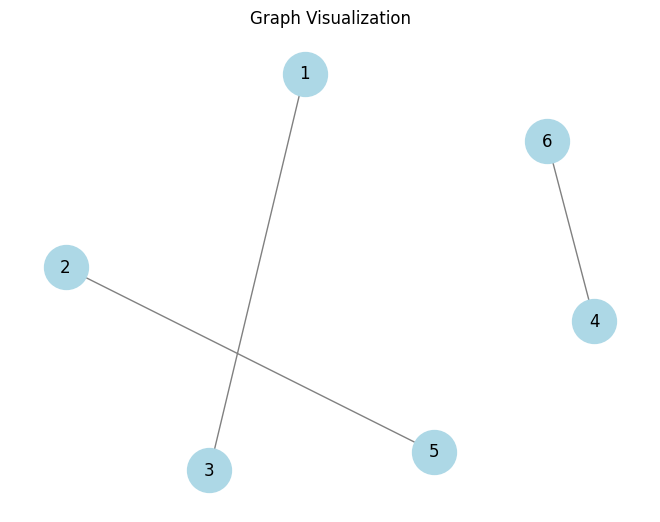

Maksymalna ilość skojarzeń: 3
Przykładowe maksymalne skojarzenia: {('4', '6'), ('1', '3'), ('2', '5')}


In [8]:
cykl_3elementowy = Graph.from_edges_list_file("cykl_3elementowy.txt", is_directed=False)
cykl_3elementowy.plot()
matchings, max_matchings  = blossom_max_matching(cykl_3elementowy, verbose=True)
print(f"Maksymalna ilość skojarzeń: {max_matchings}")
print("Przykładowe maksymalne skojarzenia:", set([(u, v) for u, v in matchings.items() if u < (v or u)]))

Wyniki algorytmu dla grafu z cyklami nieparzystymi długości 3 oraz 5:

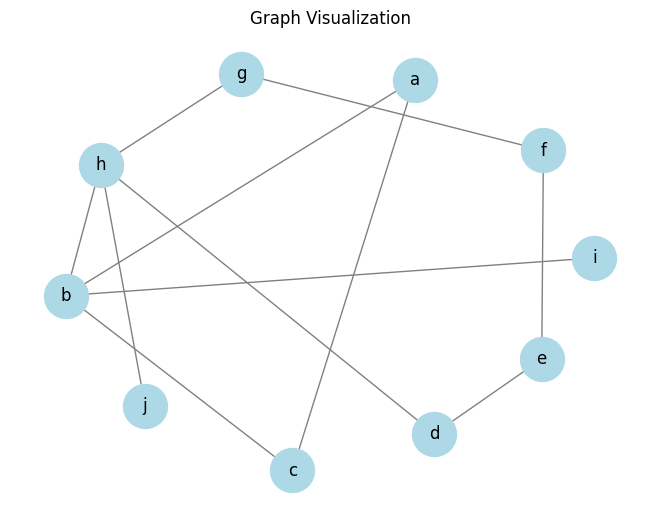

Starting alternating depth first search from vertex a.
Current matching increased to size 1. Current matching is visualised on the following graph:


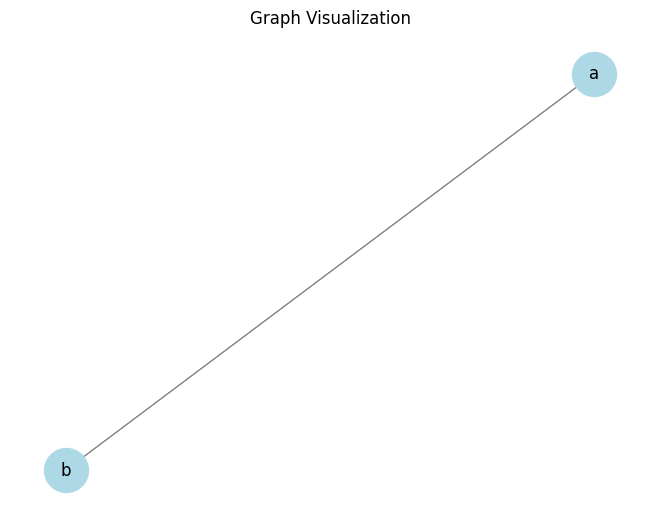

Starting alternating depth first search from vertex c.
Detected the following blossom:


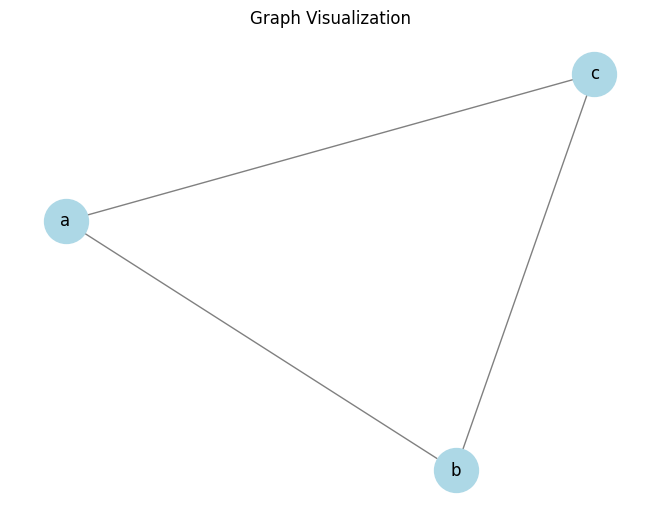

Current matching increased to size 2. Current matching is visualised on the following graph:


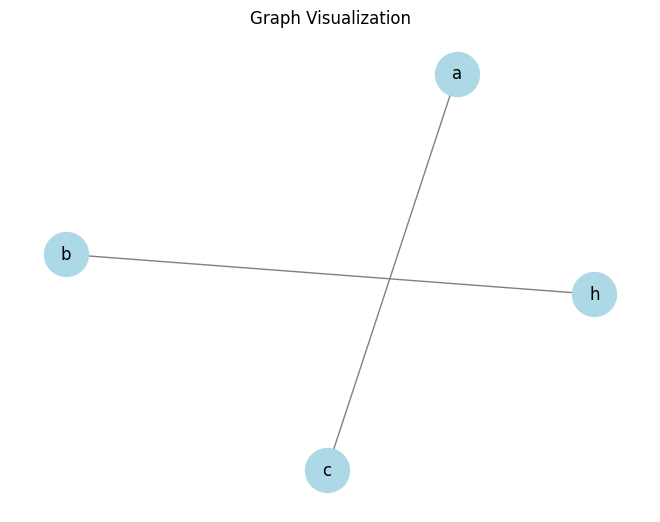

Starting alternating depth first search from vertex d.
Current matching increased to size 3. Current matching is visualised on the following graph:


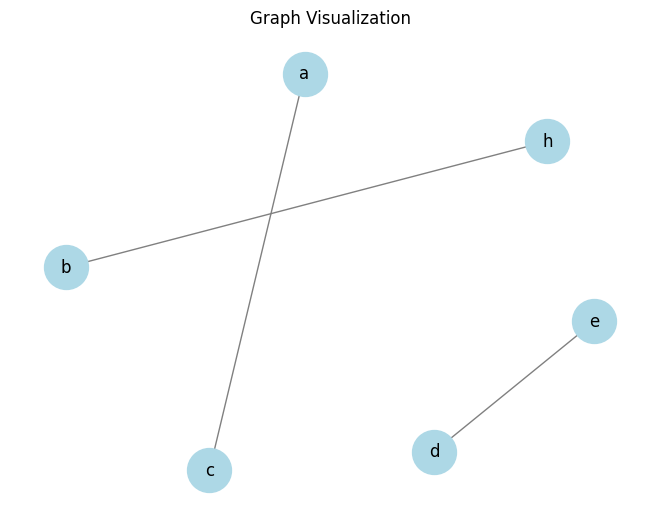

Starting alternating depth first search from vertex f.
Current matching increased to size 4. Current matching is visualised on the following graph:


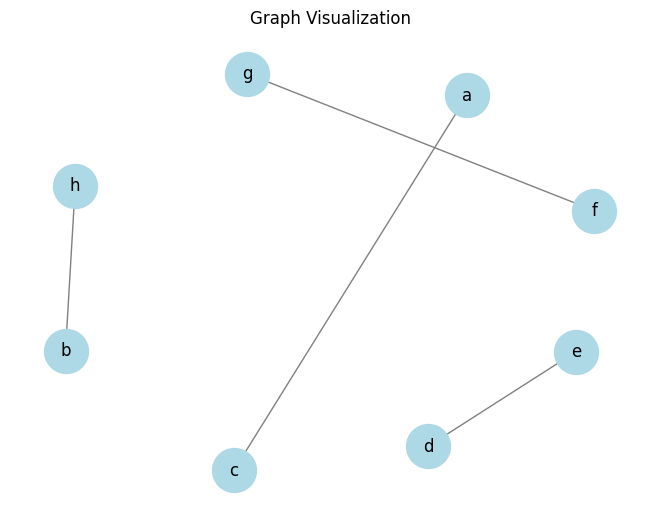

Starting alternating depth first search from vertex i.
Current matching increased to size 5. Current matching is visualised on the following graph:


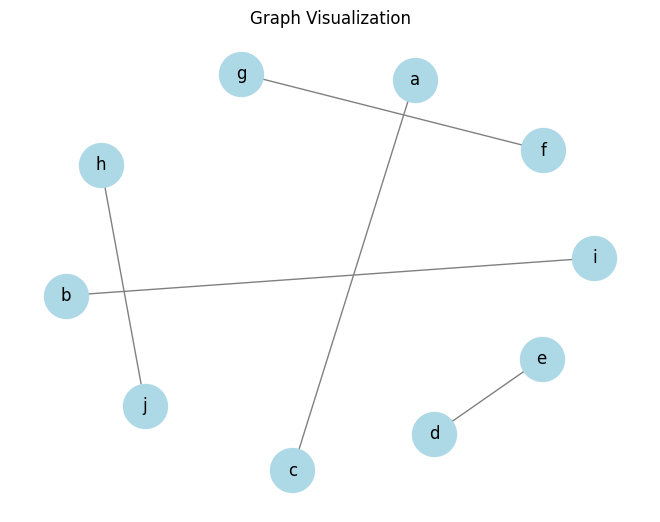

Maksymalna ilość skojarzeń: 5
Przykładowe maksymalne skojarzenia: {('h', 'j'), ('b', 'i'), ('a', 'c'), ('f', 'g'), ('d', 'e')}


In [9]:
cykle_3i5elementowe = Graph.from_edges_list_file("cykle_3i5elementowe.txt", is_directed=False)
cykle_3i5elementowe.plot()
matchings, max_matchings  = blossom_max_matching(cykle_3i5elementowe, verbose=True)
print(f"Maksymalna ilość skojarzeń: {max_matchings}")
print("Przykładowe maksymalne skojarzenia:", set([(u, v) for u, v in matchings.items() if u < (v or u)]))

Wyniki algorytmu dla losowego grafu:

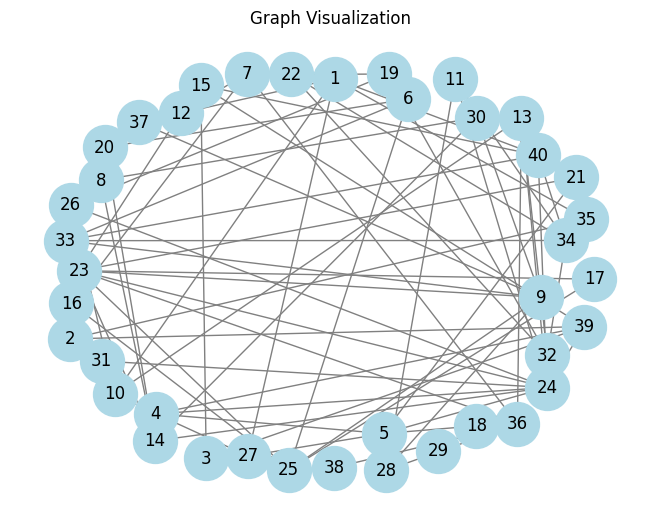

Starting alternating depth first search from vertex 1.
Current matching increased to size 1. Current matching is visualised on the following graph:


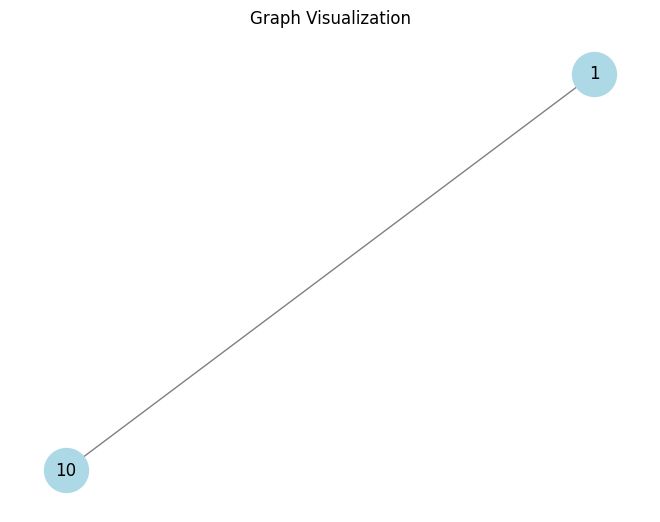

Starting alternating depth first search from vertex 2.
Current matching increased to size 2. Current matching is visualised on the following graph:


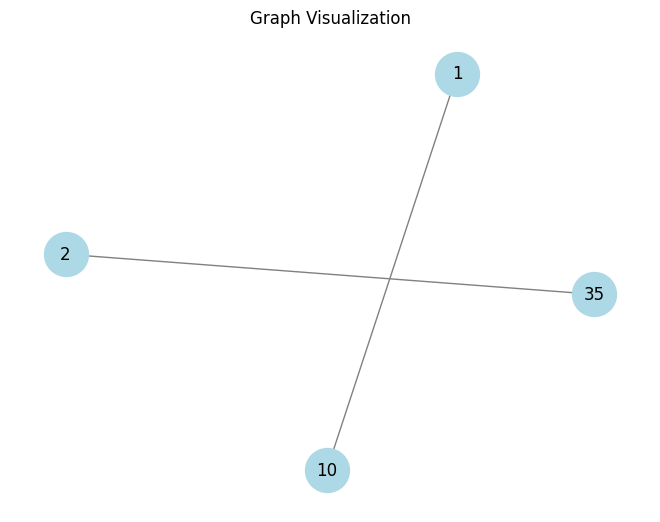

Starting alternating depth first search from vertex 3.
Current matching increased to size 3. Current matching is visualised on the following graph:


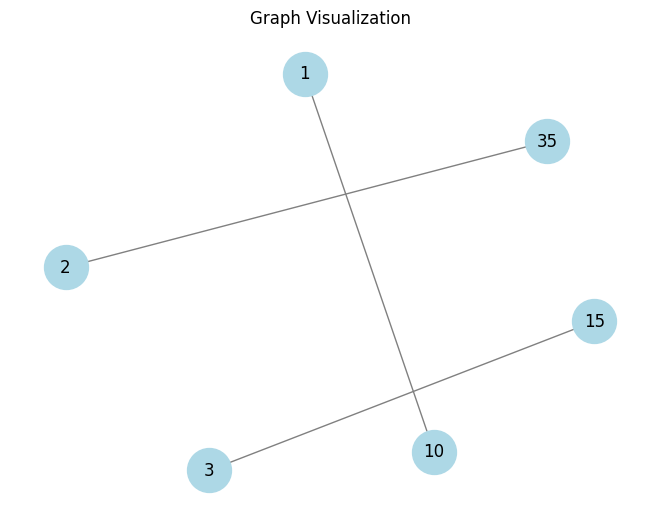

Starting alternating depth first search from vertex 4.
Current matching increased to size 4. Current matching is visualised on the following graph:


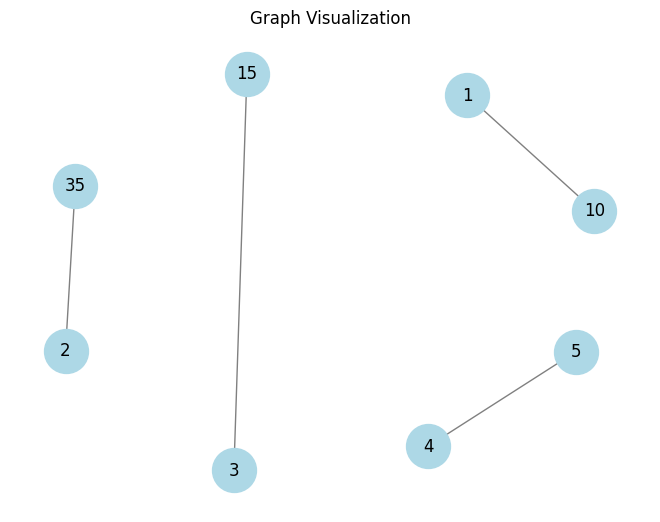

Starting alternating depth first search from vertex 6.
Current matching increased to size 5. Current matching is visualised on the following graph:


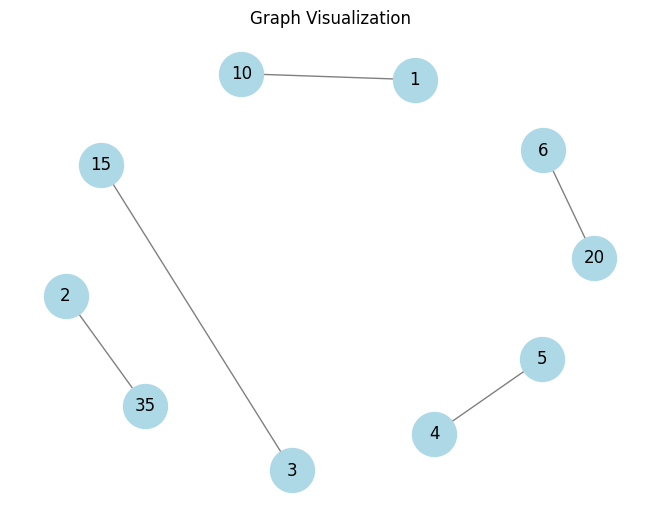

Starting alternating depth first search from vertex 7.
Current matching increased to size 6. Current matching is visualised on the following graph:


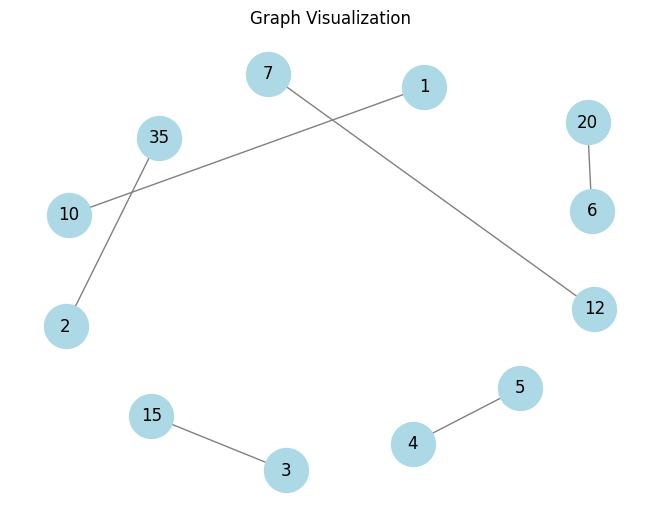

Starting alternating depth first search from vertex 8.
Current matching increased to size 7. Current matching is visualised on the following graph:


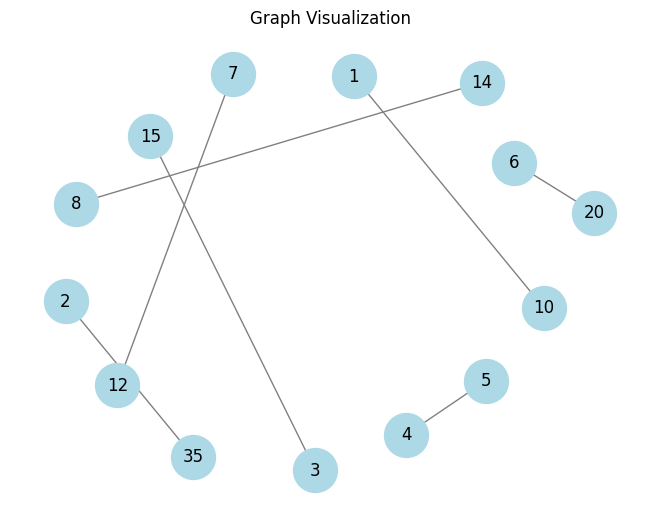

Starting alternating depth first search from vertex 9.
Current matching increased to size 8. Current matching is visualised on the following graph:


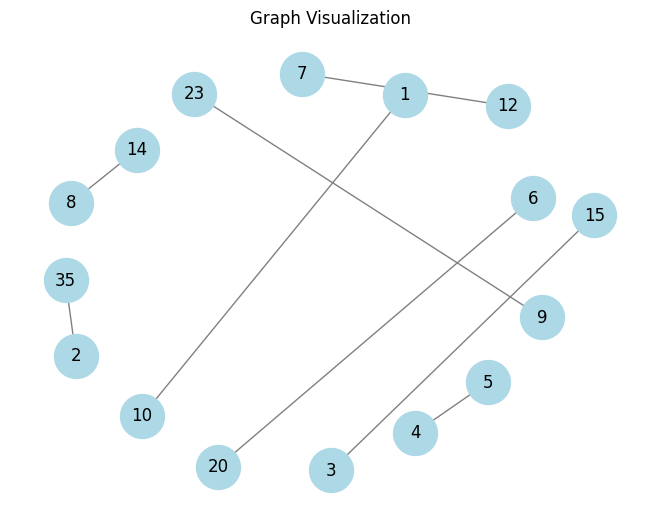

Starting alternating depth first search from vertex 11.
Current matching increased to size 9. Current matching is visualised on the following graph:


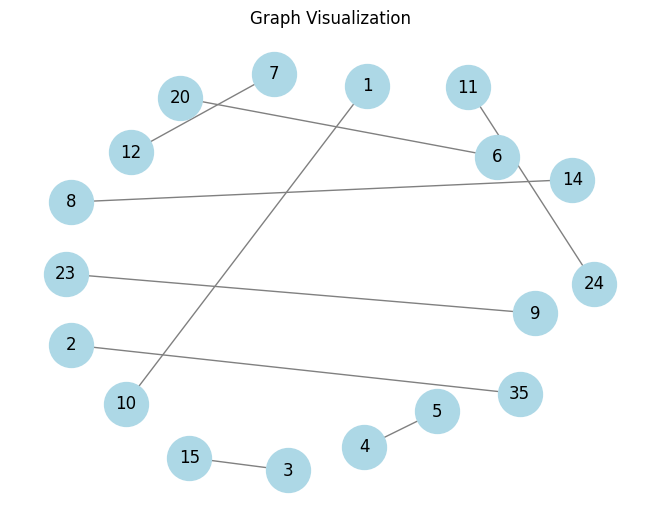

Starting alternating depth first search from vertex 13.
Current matching increased to size 10. Current matching is visualised on the following graph:


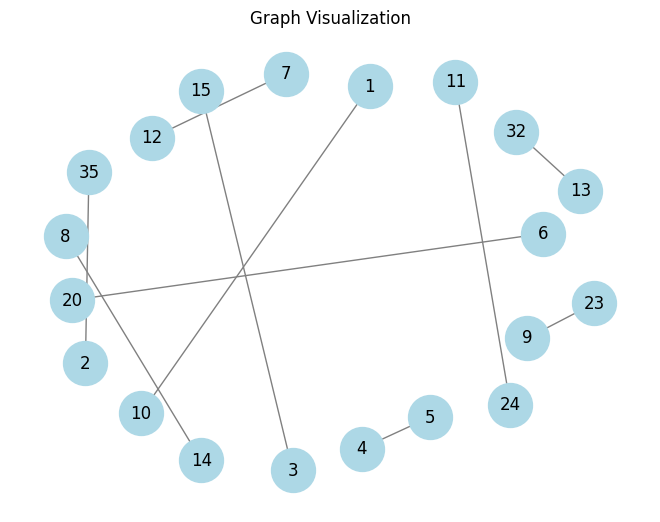

Starting alternating depth first search from vertex 16.
Current matching increased to size 11. Current matching is visualised on the following graph:


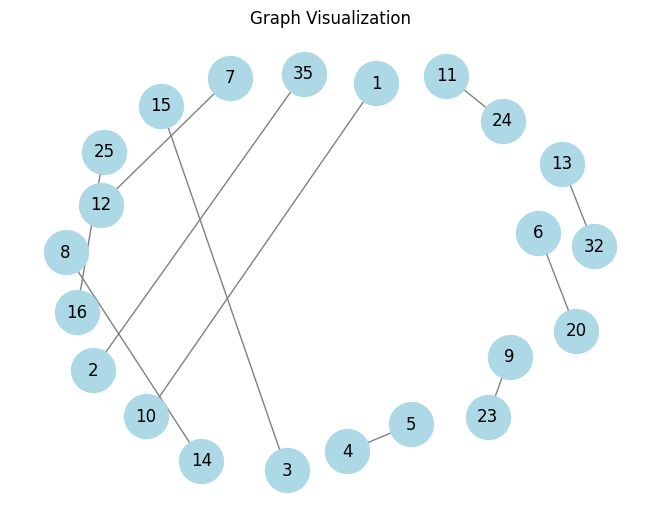

Starting alternating depth first search from vertex 17.
Current matching increased to size 12. Current matching is visualised on the following graph:


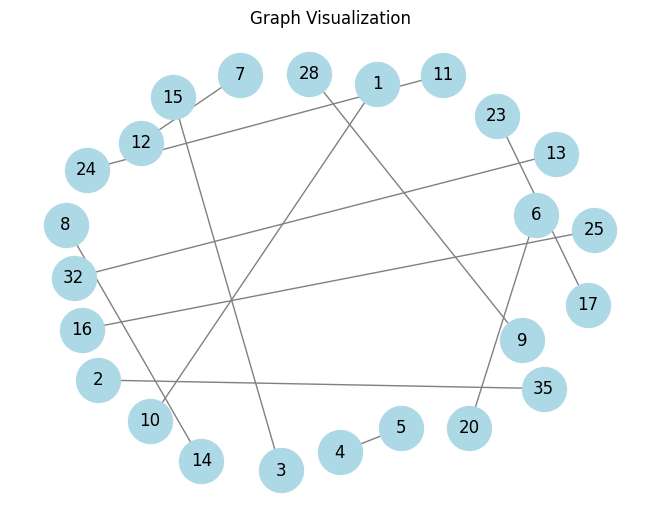

Starting alternating depth first search from vertex 18.
Current matching increased to size 13. Current matching is visualised on the following graph:


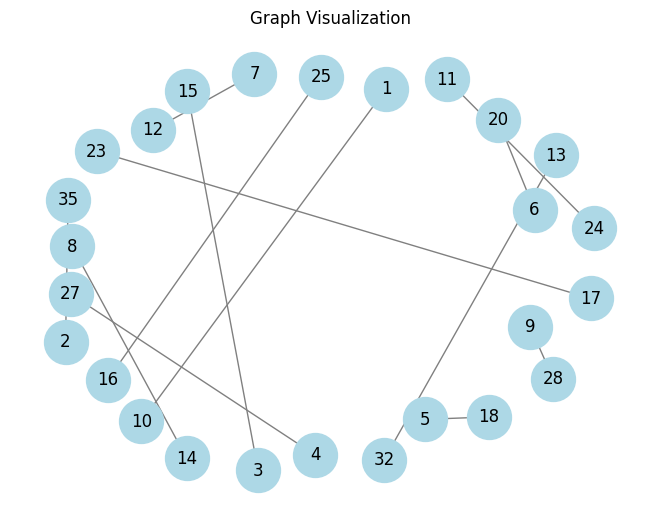

Starting alternating depth first search from vertex 19.
Current matching increased to size 14. Current matching is visualised on the following graph:


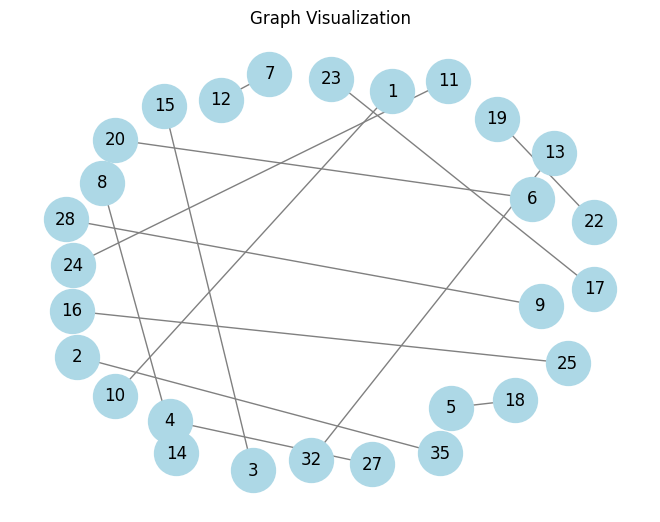

Starting alternating depth first search from vertex 21.
Current matching increased to size 15. Current matching is visualised on the following graph:


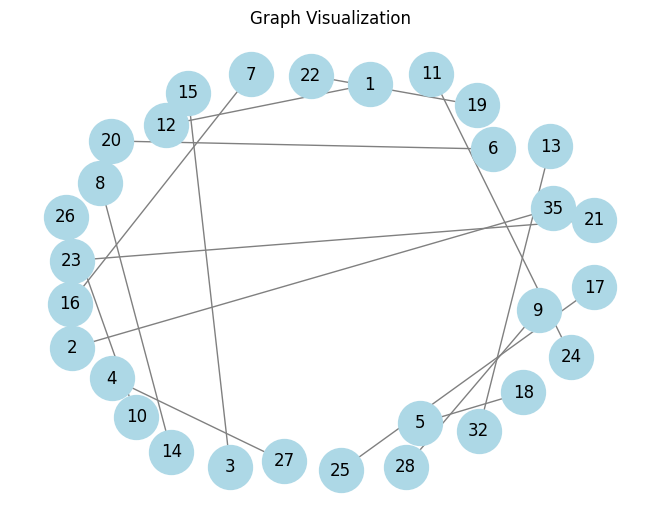

Starting alternating depth first search from vertex 29.
Starting alternating depth first search from vertex 30.
Detected the following blossom:


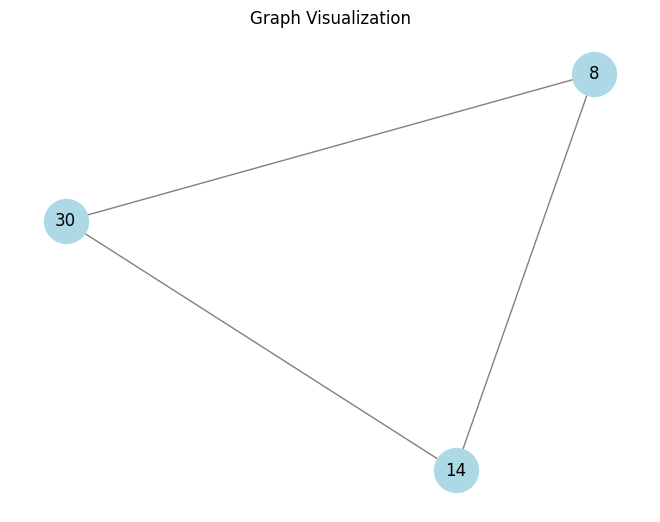

Current matching increased to size 16. Current matching is visualised on the following graph:


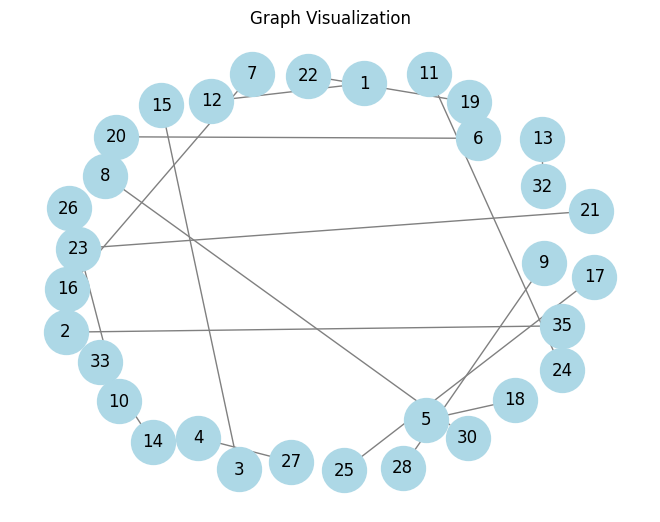

Starting alternating depth first search from vertex 31.
Current matching increased to size 17. Current matching is visualised on the following graph:


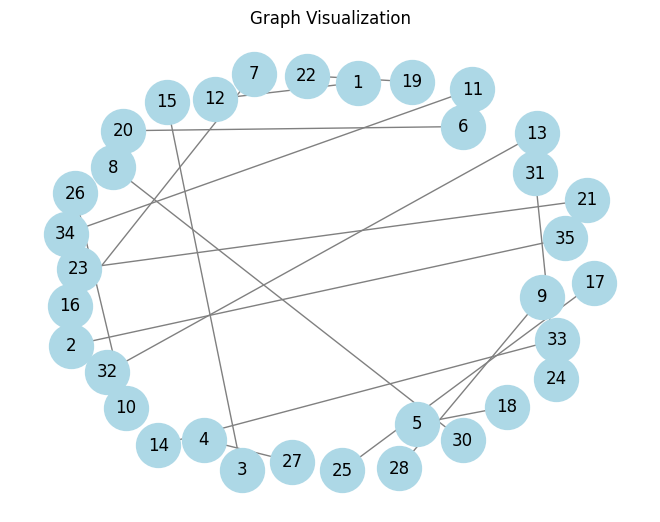

Starting alternating depth first search from vertex 36.
Current matching increased to size 18. Current matching is visualised on the following graph:


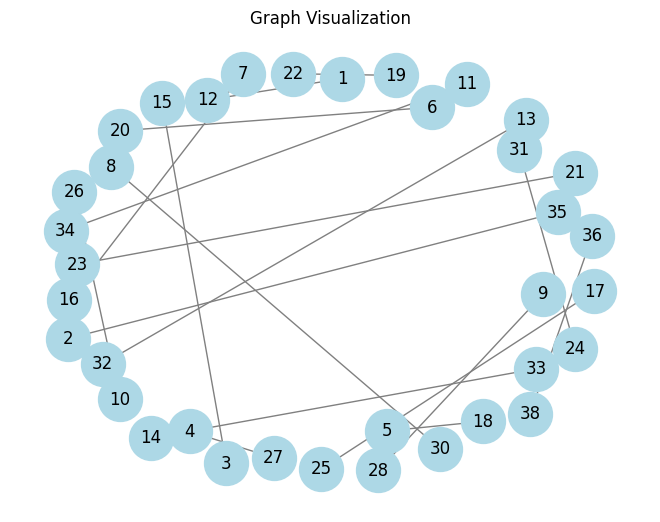

Starting alternating depth first search from vertex 37.
Current matching increased to size 19. Current matching is visualised on the following graph:


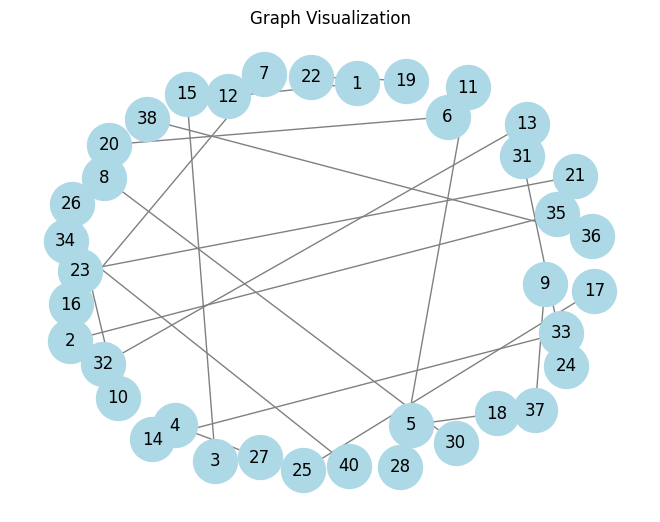

Starting alternating depth first search from vertex 39.
Detected the following blossom:


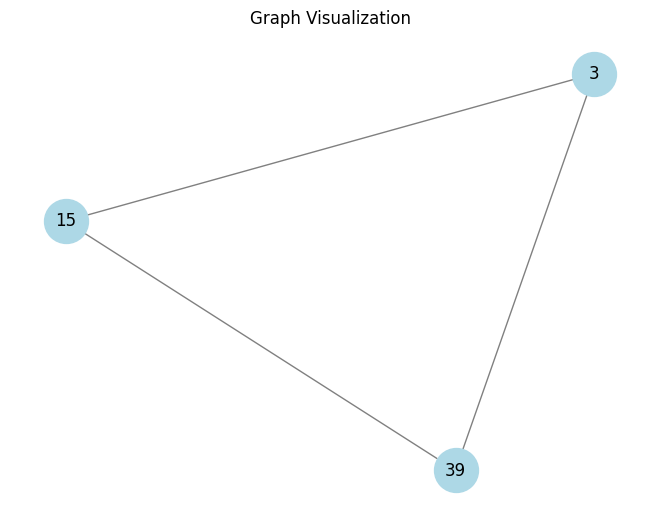

Detected the following blossom:


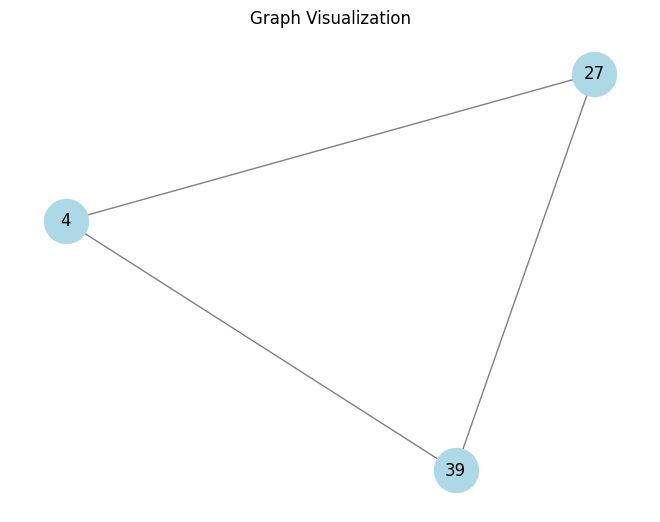

Detected the following blossom:


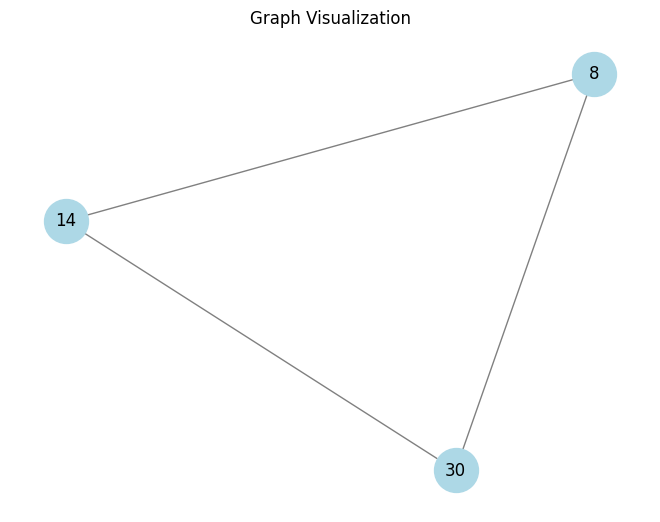

Detected the following blossom:


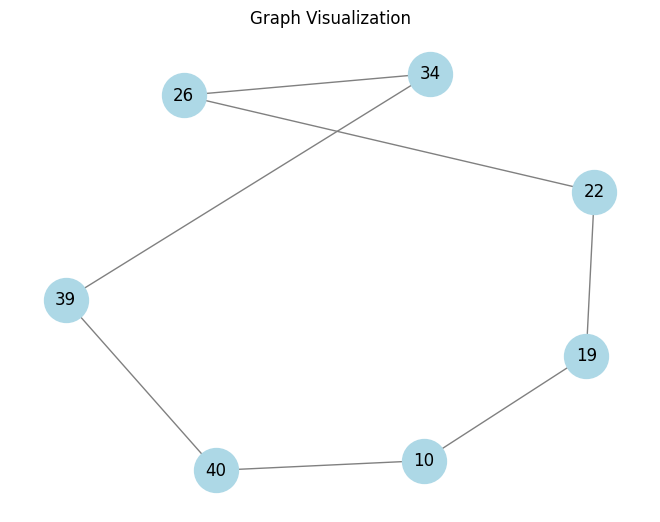

Detected the following blossom:


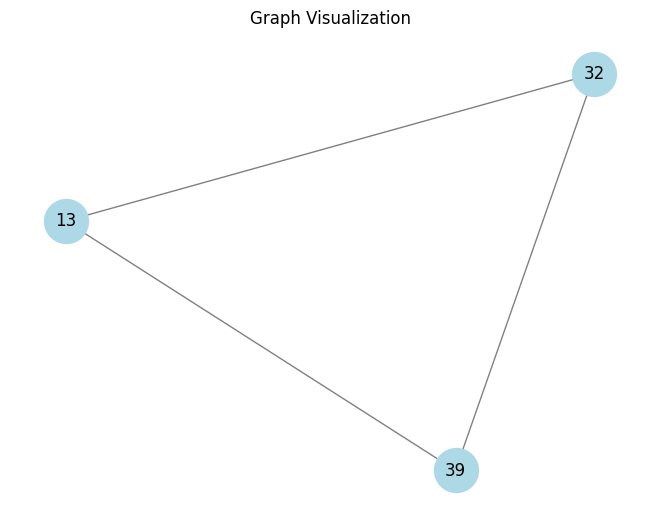

Maksymalna ilość skojarzeń: 19
Przykładowe maksymalne skojarzenia: {(4, 27), (34, 40), (1, 12), (8, 30), (7, 16), (6, 20), (2, 35), (13, 32), (3, 15), (5, 18), (14, 33), (11, 28), (10, 26), (9, 37), (24, 31), (21, 23), (17, 25), (19, 22), (36, 38)}


In [10]:
random_graph = Graph.generate_random_graph(40, prob=0.1, random_seed=1)
random_graph.plot()
matchings, max_matchings  = blossom_max_matching(random_graph, verbose=True)
print(f"Maksymalna ilość skojarzeń: {max_matchings}")
print("Przykładowe maksymalne skojarzenia:", set([(u, v) for u, v in matchings.items() if u < (v or u)]))